# <center> Analyzing NFL Twitter data using APIs and ETL processes
### <center> DS 3002 Project 2 (Course Capstone)
### <center> Thomas Burrell (tmb9ccd)
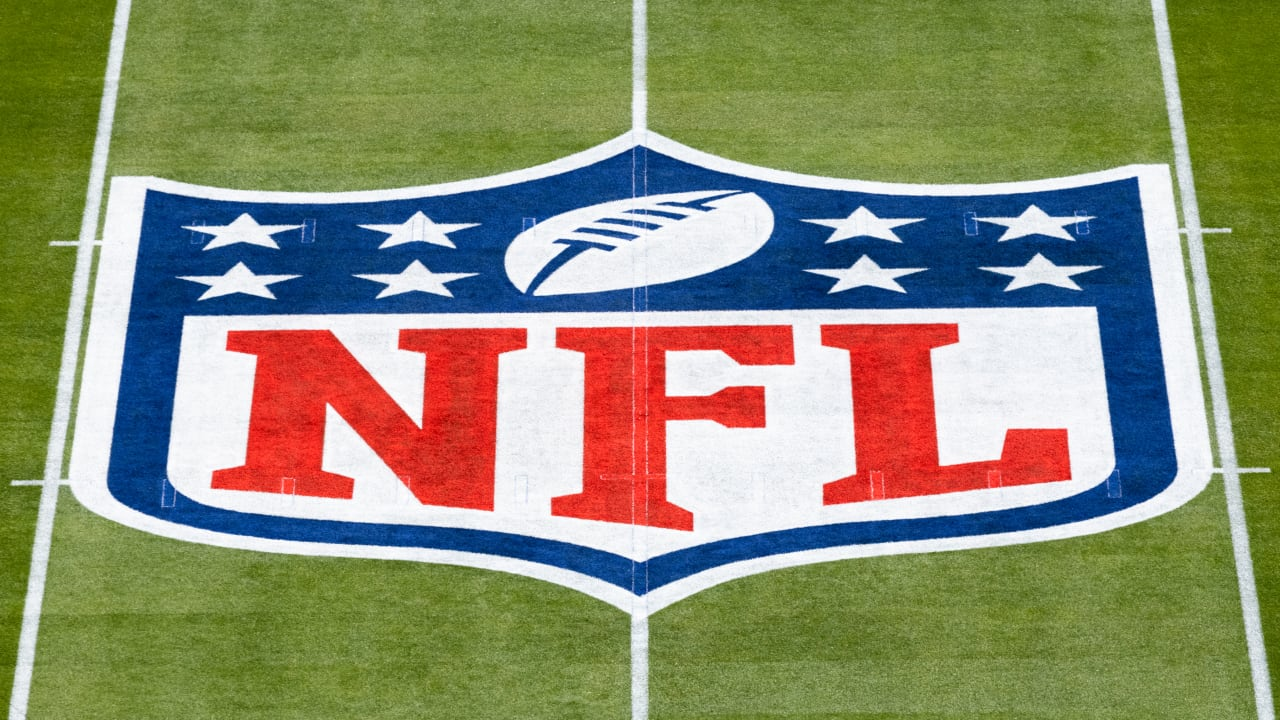

## Importing Packages

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import os
import datetime
import pymongo
import pprint
import pymysql
from pymysql.constants import ER
import requests
import json
import mysql.connector as mysql
import csv
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sqlalchemy import create_engine
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
nfl_data = pd.read_csv("nfl_teams.csv")

team_names = []

for name in nfl_data['Name']:
    team_names.append(name)

team_win_pct = pd.read_csv("WinPCT.csv")
team_win_pct = team_win_pct.sort_values(by='Team').iloc[:,[0,4]]

In [3]:
tweets_list = []
count = 0

team_names_query = []

for i in team_names:
    team_names_query.append(i + " until:2022-05-03 since:2022-05-01")


for team in team_names_query:
    for tweet in sntwitter.TwitterSearchScraper(team).get_items():
        if count == 30:
            count = 0
            break
        else:
            tweets_list.append([tweet.id, tweet.date, tweet.user.username, tweet.content,
                                tweet.user.followersCount, tweet.user.friendsCount,
                                tweet.user.location, tweet.likeCount, team.split('until')[0]])
            count += 1
        
tweets_df = pd.DataFrame(tweets_list, columns=['ID','Date', 'User', 'Tweet','Followers', 'Following', 'Location', 'Likes', 'Team'])

tweets_df_date = tweets_df['Date'].reset_index()

tweets_df = tweets_df.drop(columns=["Date"])

tweets_df.head()

,ID,User,Tweet,Followers,Following,Location,Likes,Team
0,1521278245072740352,GoodNews_Please,@OhioStateFB @cbooks13 @AZCardinals 🌰💯🅾️‼️❗️,1433,3046,CT,1,Arizona Cardinals
1,1521277969603432451,BmbEmpower,#Arizona #Cardinals WR #DeAndreHopkins suspend...,240,751,"Dallas, TX",0,Arizona Cardinals
2,1521277925911236608,OnlyAzSports,"Whelp, since Hopkins is suspended the @AZCardi...",49,152,,0,Arizona Cardinals
3,1521277660437098497,Blahbla21206217,@Wyvern04Ghost @AZCardinals @Primetime_jet 5th...,0,0,Your head,0,Arizona Cardinals
4,1521276794497908736,JustinCoderre,OBJ should sign with the @AZCardinals,67,420,Canada,0,Arizona Cardinals


## Sentiment Analysis

In [4]:
tweet = tweets_df['Tweet']

# precprcess tweet

tweet_proc2 = []

for i in tweet:
    tweet_words = []
    for word in i.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)
        tweet_proc = " ".join(tweet_words)
    tweet_proc2.append(tweet_proc)

# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']



sentiment_lab = []

# sentiment analysis
for tweet in tweet_proc2:
    encoded_tweet = tokenizer(tweet, return_tensors='pt')
    output = model(**encoded_tweet)
    
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    max_sc = max(scores)
    result = np.where(scores == max_sc)
    if result[0][0] == 0:
        result = "negative"
    elif result[0][0] == 1:
        result = "neautral"
    elif result[0][0] == 2:
        result = "positive"
    sentiment_lab.append(result)
    
tweets_df['Sentiment'] = sentiment_lab


group_tweets_1 = tweets_df.groupby(tweets_df["Team"]).count().sort_values(by = "User", ascending=[False]) #Group by airline & count tweets
group_tweets_1.rename(columns = {'ID':'Number of tweets'}, inplace = True) #rename column to make more sense
grouped_tweets_1 = group_tweets_1.iloc[:,0]

negative = tweets_df.loc[tweets_df['Sentiment'] == 'negative'] # get the negative tweets
negative_grouped = negative.groupby(negative["Team"]).count().iloc[:,0]

neg = negative_grouped/grouped_tweets_1
neg = neg.fillna(0)

neg_tweets_df = pd.DataFrame(neg, columns=['Neg_Sentiment_PCT']).reset_index()

## Connect to SQL 

In [5]:
host_name = "localhost"
host_ip = "127.0.0.1"
port = "3306"
user_id = "root"
pwd = "dwkd82!hh"

src_dbname = "Tweets"
dst_dbname = "Tweets"

In [6]:
def get_dataframe(user_id, pwd, host_name, db_name, sql_query):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    dframe = pd.read_sql(sql_query, connection);
    connection.close()
    
    return dframe


def set_dataframe(user_id, pwd, host_name, db_name, df, table_name, pk_column, db_operation):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    
    if db_operation == "insert":
        df.to_sql(table_name, con=connection, index=False, if_exists='replace')
        sqlEngine.execute(f"ALTER TABLE {table_name} ADD PRIMARY KEY ({pk_column});")
            
    elif db_operation == "update":
        df.to_sql(table_name, con=connection, index=False, if_exists='append')
    
    connection.close()
    
conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)

sqlEngine.execute(f"DROP DATABASE IF EXISTS `{dst_dbname}`;")
sqlEngine.execute(f"CREATE DATABASE `{dst_dbname}`;")
sqlEngine.execute(f"USE {dst_dbname};")

In [7]:
db_operation = "insert"
table_name = "tweets_fact_table"
primary_key = "ID"
dataframe = tweets_df

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

IntegrityError: (pymysql.err.IntegrityError) (1062, "Duplicate entry '1521231171774038021' for key 'tweets_fact_table.PRIMARY'")
[SQL: ALTER TABLE tweets_fact_table ADD PRIMARY KEY (ID);]
(Background on this error at: http://sqlalche.me/e/13/gkpj)

In [8]:
db_operation = "insert"
table_name = "Neg_sent_table"
primary_key = "Team"
dataframe = neg_tweets_df

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

C:\Users\treyb\anaconda3\lib\site-packages\pandas\io\sql.py:1333: UserWarning: The provided table name 'Neg_sent_table' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


OperationalError: (pymysql.err.OperationalError) (1170, "BLOB/TEXT column 'Team' used in key specification without a key length")
[SQL: ALTER TABLE Neg_sent_table ADD PRIMARY KEY (Team);]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [9]:
db_operation = "insert"
table_name = "Tweets_Date"
primary_key = "index"
dataframe = tweets_df_date

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

C:\Users\treyb\anaconda3\lib\site-packages\pandas\io\sql.py:1333: UserWarning: The provided table name 'Tweets_Date' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'index)' at line 1")
[SQL: ALTER TABLE Tweets_Date ADD PRIMARY KEY (index);]
(Background on this error at: http://sqlalche.me/e/13/f405)

In [10]:
db_operation = "insert"
table_name = "Team_Win_PCT"
primary_key = "index"
dataframe = team_win_pct

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

C:\Users\treyb\anaconda3\lib\site-packages\pandas\io\sql.py:1333: UserWarning: The provided table name 'Team_Win_PCT' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'index)' at line 1")
[SQL: ALTER TABLE Team_Win_PCT ADD PRIMARY KEY (index);]
(Background on this error at: http://sqlalche.me/e/13/f405)

## Write Tweets_df to a CSV file

In [ ]:
tweets_df.to_csv('tweets_proj_2.csv')

## Convert CSV to JSON

In [ ]:
data = open('tweets_proj_2.csv', encoding="utf8").readlines()
tweets_json = json.dumps(list(csv.reader(data)))


## Connect to MongoDB

In [ ]:
mysqldb = mysql.connect(host="localhost", database="tweets", user="root", password="dwkd82!hh")
mycursor = mysqldb.cursor(dictionary=True) 
mycursor.execute("SELECT * from tweets_fact_table;") 
myresult = mycursor.fetchall() 
print(myresult)

In [ ]:
host_name = "localhost"
port = "27017"

try:
    conn_str = f"mongodb://{host_name}:{port}/"
    client = pymongo.MongoClient(conn_str)
except ValueError:
    print("Make sure your port number is correct, then retry")

In [ ]:
db = client["Twitter_Data"]
collection = db['Tweets']

In [ ]:
if len(myresult) > 0:
        x = collection.insert_many(myresult) #myresult comes from mysql cursor
        print(len(x.inserted_ids))